# ARC-LIGHT DEMONSTRATION FOR HULC 2024

# Set up

In [48]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import miepython
import copy
from scipy.spatial import cKDTree
import pandas as pd
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from PIL import Image, ImageFilter
from matplotlib import colormaps
import torch.optim as optim
import torch.nn as nn
from os import listdir
from os.path import isfile, join
import re
import random
import imageio.v2 as iio
import csv
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import os

In [49]:
# Define functions
def get_files(dir, key=".*\.png"):
    # For a directory "dir", return a list of all files which match the regex expression "key"
    all_files = [f for f in listdir(dir) if isfile(join(dir, f))]
    files=[]
    for file in all_files:
        match = re.search(key,file)
        if match != None:
            files.append(file)
    files.sort()
    return files

def get_image(image_path, size, trim):
    """Get a numpy array of an image so that one can access values[x][y]."""
    image = Image.open(image_path, "r")
    image = image.resize((size,size))
    pixel_values = list(image.getdata())
    if image.mode == "RGB":
        channels = 3
    elif image.mode == "L":
        channels = 1
    elif image.mode == "RGBA":
        channels = 4
    else:
        print("Unknown mode: %s" % image.mode)
        return None
    pixel_values = np.array(pixel_values).reshape((size, size, channels))
    sum_vales = (pixel_values[:,:,0]+pixel_values[:,:,1]+pixel_values[:,:,2])[trim:-trim,trim:-trim]
    return sum_vales[:,:]/sum_vales[:,:].max()

def get_scan(file, theta0, dtheta, trim):
    # Reads a lidar scan "file", returns the xz and rtheta coordinates of the points, as well as the optical depth for that file
    rows=[]
    with open(file, 'r') as fd:
        reader = csv.reader(fd)
        for row in reader:
            rows.append(row)
    data = rows[35][0].split(';')
    r = [float(string) for string in data]
    theta = np.linspace(-theta0,-theta0+len(r)*dtheta,len(r))
    x = r*np.sin(theta)
    z = r*np.cos(theta)
    xz = np.column_stack((x, z))
    rtheta = np.column_stack((r, theta))
    #blue = int(re.search(".*_(.)\.ubh",file)[1]) # This regex line pulls out v_max 
    return xz[trim:-trim,:], rtheta[trim:-trim,:]

def load_checkpoint(model, optimizer, losslogger, filename="trained_model"):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        losslogger = checkpoint['losslogger']
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch, losslogger

=> loading checkpoint 'trained_model'
=> loaded checkpoint 'trained_model' (epoch 6200001)


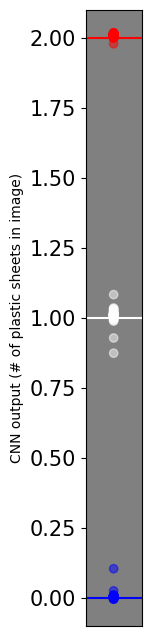

In [50]:
# Read in the trained CNN and show some sample results
sample_dir = "blue_photos/"
image_size = 300 # photo will be read in as size x size
image_trim = 100 # remove this many pixels from each edge

# Set CNN hyperparameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 1e-3
losses = []
hidden = 64

# Load it
model = nn.Sequential(
  nn.Linear((image_size-2*image_trim)**2, hidden),
  nn.ReLU(),
  nn.Linear(hidden, hidden),
  nn.Sigmoid(),
  nn.Linear(hidden,1),
).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)
model, optimizer, start_epoch, losslogger = load_checkpoint(model, optimizer, losses)
model = model.to(device)
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

# Read in images
sample_files = get_files(sample_dir)
sample_blue_ls = []
sample_im_ls = []
for file in sample_files:
    blue = int(re.search(".*_(.).png",file)[1]) # This regex line pulls if there is a panel or not
    im = get_image(str(sample_dir+file),image_size,image_trim)
    sample_blue_ls.append(blue)
    sample_im_ls.append(im)

# Show a quick test:
sample_im_tensor = torch.tensor(np.reshape(sample_im_ls, (len(sample_im_ls),(image_size-2*image_trim)**2))).float().to(device)
sample_blue_tensor = torch.tensor(np.reshape(sample_blue_ls, (len(sample_blue_ls),1))).float().to(device)
yhat_ls=[]
for i in range(0,len(sample_im_ls)):
    yhat = model(sample_im_tensor[i])*2
    yhat_ls.append(yhat.detach().numpy().item())
fig, ax = plt.subplots(figsize=(4,8))
ax.scatter(np.zeros_like(yhat_ls),yhat_ls,c=sample_blue_tensor.detach().numpy()[:,0],cmap="bwr",alpha=0.5)
ax.set_facecolor('grey')
ax.plot([-0.1,0.1],[0,0],color='blue')
ax.plot([-0.1,0.1],[1,1],color='white')
ax.plot([-0.1,0.1],[2,2],color='red')
ax.set_aspect("equal")
ax.tick_params(axis='both', labelsize=15)
ax.set_xlim(-0.1,0.1)
ax.set_ylim(-0.1,2.1)
ax.set_xticks([])
ax.set_ylabel("CNN output (# of plastic sheets in image)")
plt.show()


In [51]:
# Set lidar input
chi1 = 0.6980549604963439
chi2 = 0.6108273665379517
dtheta = 0.25/180*np.pi # step size, radians
theta0 = 8/180*np.pi # Initial angle of lidar scan, in radians
scan_trim = 1

# Demo

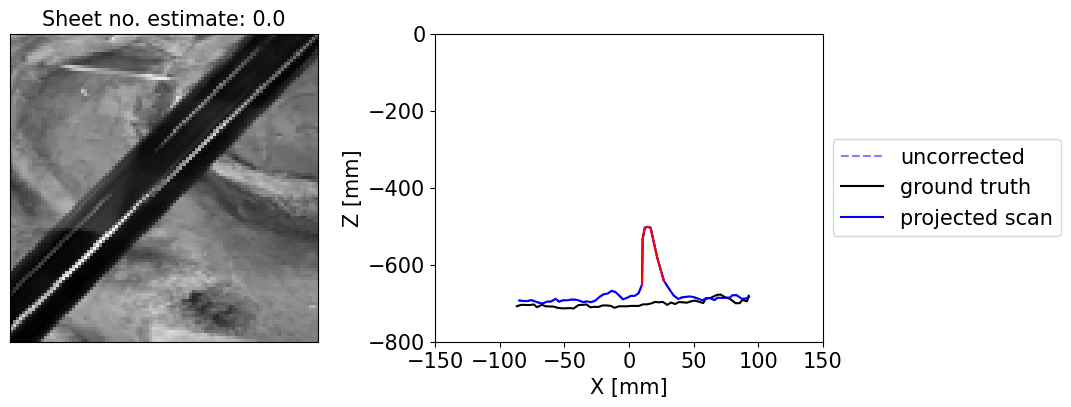

In [69]:
# Identify demo files
dir='live_demo/'
image_file = get_files(dir,".*\.png")[0]
scan_file = get_files(dir,".*\.ubh")[0]

# Read in
im = get_image(str(dir+image_file),image_size,image_trim)
sc = get_scan(str(dir+scan_file),theta0,dtheta,scan_trim)

# Also read in baselines
#im0 = get_image(str(dir+image_file),mage_sizesize,image_trim)
sc0 = get_scan("baseline/0005_0.ubh",theta0,dtheta,scan_trim)

# Convert to a tensor and evaluate
im_tensor = torch.tensor(np.reshape(im, (1,(image_size-2*image_trim)**2))).float().to(device)

# Guess the number of blue sheets using the CNN
yhat = model(im_tensor[0]).detach().numpy().item()*2

# Set chi
if yhat<0.5:
    chi=1
elif yhat<1.5:
    chi=chi1
else:
    chi=chi2

# Apply this to get the distance the lidar should have scanned
r_corrected = sc[1][:,0] / chi
x_corrected = r_corrected * np.sin(sc[1][:,1])
z_corrected = - r_corrected * np.cos(sc[1][:,1])

# Plot reconstruction
fig, ax = plt.subplots(ncols=2,figsize=(11,4))
ax[0].imshow(im,cmap="grey")
ax[0].set_title("Sheet no. estimate: "+str(round(yhat,1)),fontsize=15)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].plot(-sc[0][:,0],-sc[0][:,1],c="blue",linestyle="dashed",alpha = 0.5,label="uncorrected")
ax[1].plot(-sc0[0][:,0],-sc0[0][:,1],color="black",linestyle = "solid",alpha=1,label="ground truth")
ax[1].plot(-x_corrected, z_corrected,c="blue",label="projected scan")
# Find points which could be target
mask = np.abs(z_corrected+sc0[0][:,1])>40
# Trim any single isolated points
for i in range(1,len(mask)-1):
    if mask[i]:
        if (mask[i-1]==False and mask[i+1]==False):
            mask[i]=False
# Plot target only if mask is a certain length
if len(mask[mask])>3 and len(mask[mask])<12:
    ax[1].plot(-x_corrected[mask],z_corrected[mask],c="red")

ax[1].set_xlim(-150,150)
ax[1].set_ylim(-800,0)
ax[1].set_xlabel("X [mm]",fontsize=15)
ax[1].set_ylabel("Z [mm]",fontsize=15)
ax[1].tick_params(axis='both', labelsize=15)
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15)
plt.show()